# Sakila Films Rentals

## Introduction

The purpose of this notebook is to revisit a previous project where I analysed data queried from the *sakila `dvdrental` database* and exported as `.csv` files into Excel. The previous analysis was performed with PostgreSQL and Microsoft Excel.

The aim is to assess my growth as a data analyst using Python and other tools and libraries such as pandas and visualizing with matplotlib and seaborn.

I will carry out my analysis in several phases. But I intend to first replicate the initial work done in Excel using only Python from querying the data from the database with sqlalchemy or pandas to reporting my findings with matplotlib and seaborn.

I will also try to make some inference if the opportunity arises.

 The below image shows the Entity Relationship Diagram (*ERD*) for *Sakila DVD rentals* ![ERD for Sakila DVD rentals](./dvd-rental-sample-database-diagram.png)

A connection to the database must be initiated before data can be queried from it. I have defined the connection parameters as enviroment variables in my environment and will access these variables using the **`os`** built-in Python package.

In [1]:
import os

PGUSER = os.environ.get('PGUSER')
PGPASSWORD = os.environ.get('PGPASSWORD')
PGHOST = os.environ.get('PGHOST')
PGPORT = os.environ.get('PGPORT')
# [PGHOST, PGPASSWORD, PGUSER, PGPORT]
del os

I have deleted the **`os`** as it is no longer needed.

I will use the **`create_engine`** function from the **`SQLAlchemy`** package to create an engine to connect to the database.

I will import other necessary libraries and tools relevant to this project such as **`numpy`**, **`pandas`** and **`pyplot`** from **`matplotlib`**.

I will also do some initial set up  to ease my work flow.

In [2]:
from sqlalchemy import create_engine
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

%matplotlib inline
warnings.filterwarnings('ignore')
base_color = sns.color_palette()[0]

I will connect to the database with the required access parameters.

In [3]:
if None not in (PGUSER, PGPASSWORD, PGHOST, PGPORT):
    engine =  create_engine(f"postgresql://{PGUSER}:{PGPASSWORD}@{PGHOST}:{PGPORT}/dvdrentals")
    
len(engine.table_names())

15

There are **15** tables in the *Sakila films rentals* database.

The below function will encapsulate repetitive actions.

In [4]:
def query_db(query):
    with engine.connect() as conn:
        results = conn.execute(query).fetchall()
    
    return results

I want to test my function by checking  the number of records in each table in the database.

The number of records in each table is summarized below.

In [5]:
import re

s_es = r's$'
y_ies = r'y$'

for table in engine.table_names():
    query = f'SELECT COUNT(*) FROM {table}'
    row_count = query_db(query)[0].count
    table_plural = re.sub(y_ies, 'ies', table) if re.search(y_ies, table)\
                    else re.sub(s_es, 'ses', table) if re.search(s_es, table)\
                    else table+'s'
    print(f'Table {table.capitalize()}: {row_count} {table_plural.replace("_", " ")}')
    
del re

Table Actor: 200 actors
Table Store: 2 stores
Table Address: 603 addresses
Table Category: 16 categories
Table City: 600 cities
Table Country: 109 countries
Table Customer: 599 customers
Table Film_actor: 5462 film actors
Table Film_category: 1000 film categories
Table Inventory: 4581 inventories
Table Language: 6 languages
Table Rental: 16044 rentals
Table Staff: 2 staffs
Table Payment: 14596 payments
Table Film: 1000 films


### Question 1: Which Movie Categories Are Families Watching?
We are interested in the top trending family movies.

I'm not so sure as to which categories are frequently watched ny families but  assume the below categories
- Animation
- Children
- Classics
- Comedy
- Family
- Music

So I will compare the rentals within these categories.

In [6]:
query = """
        WITH family_rentals AS (
            SELECT name category, COUNT(*) rental_count
            FROM rental r
            JOIN inventory i ON i.inventory_id = r.inventory_id
            JOIN film f ON f.film_id = i.film_id
            JOIN film_category fc ON fc.film_id = f.film_id
            JOIN category c ON c.category_id = fc.category_id
            GROUP BY category ORDER BY category
            )
        SELECT * FROM family_rentals
        WHERE category IN ('Animation', 'Children', 'Classics', 'Comedy', 'Family', 'Music')
        """    
results = query_db(query)
df = pd.DataFrame(results)
df

,category,rental_count
0,Animation,1166
1,Children,945
2,Classics,939
3,Comedy,941
4,Family,1096
5,Music,830


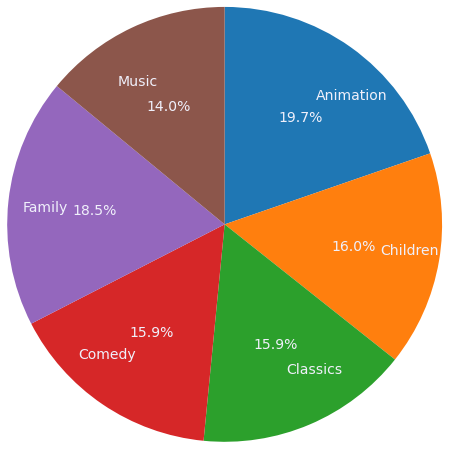

In [7]:
plt.pie(data=df, x='rental_count', labels='category', 
        startangle=90, counterclock=False, autopct="%.1f%%",
        labeldistance=0.725, radius=2.5,
       textprops={"color": '#f0f0fb', "size": 14});

The pie chart above shows the comparison between the categories in which I'm interested. However, without the text annotation, it is hard to visually conclude on the least rented category or the most rented category.

I will plot a barplot showing the categories against the counts below.

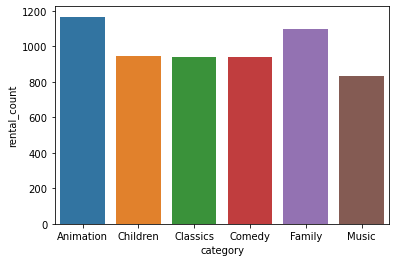

In [8]:
sns.barplot(data=df, x='category', y='rental_count');

I will use only one colour as other colours adds no further meaning and only makes the plot noisy.

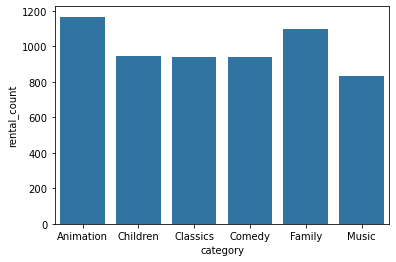

In [9]:
sns.barplot(data=df, x='category', y='rental_count', color=base_color);

Rental count values are now more easily inferred intuitively. To increase intuitveness, I will
- display the category bars by order of rental counts,
- display the chart horizonally,
- increase the chart size.

In [10]:
df.sort_values('rental_count', inplace=True, ascending=False, ignore_index=True)
df

,category,rental_count
0,Animation,1166
1,Family,1096
2,Children,945
3,Comedy,941
4,Classics,939
5,Music,830


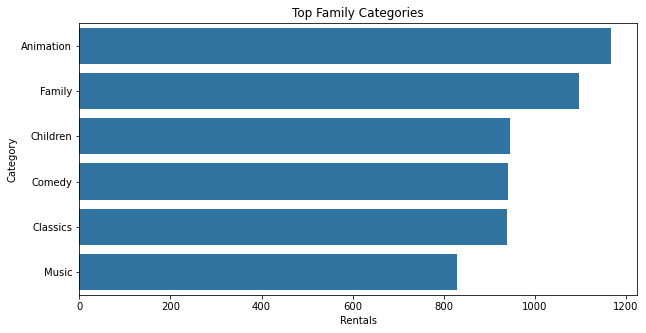

In [11]:
fig = plt.figure(figsize=(10, 5))
sns.barplot(data=df, y='category', x='rental_count', color=base_color)
plt.xlabel('Rentals')
plt.ylabel('Category')
plt.title('Top Family Categories')

fig.savefig('images/top-family-categories.png')

If my assumption is correct, Animations are the most watched/rented movie category by families with music as the least watched family category.

### Question 2: What is The Rental Duration of Family Categories?

In [12]:
query = """
        WITH rental_durations AS (
            SELECT  name category, rental_duration,
                    NTILE(4) OVER (ORDER BY rental_duration) rent_dur_standard_quartile
            FROM film f
            JOIN film_category fc ON fc.film_id = f.film_id
            JOIN category c ON c.category_id = fc.category_id
        )
        SELECT category, rent_dur_standard_quartile, COUNT(*) rent_count FROM rental_durations
        WHERE category IN ('Animation', 'Children', 'Classics', 'Comedy', 'Family', 'Music')
        GROUP BY 1, 2
        """

In [13]:
results = query_db(query)
df = pd.DataFrame(results)
df.head()

,category,rent_dur_standard_quartile,rent_count
0,Animation,1,22
1,Animation,2,10
2,Animation,3,16
3,Animation,4,18
4,Children,1,15


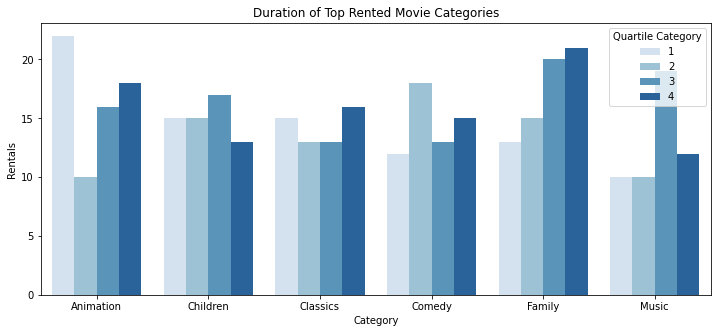

In [14]:
fig = plt.figure(figsize=(12, 5))
g = sns.barplot(x='category', y='rent_count', hue='rent_dur_standard_quartile',
                data=df, palette='Blues')
plt.xlabel('Category')
plt.ylabel('Rentals')
plt.title('Duration of Top Rented Movie Categories')
plt.legend(title='Quartile Category')

fig.savefig('images/top-movies-duration-single.png')

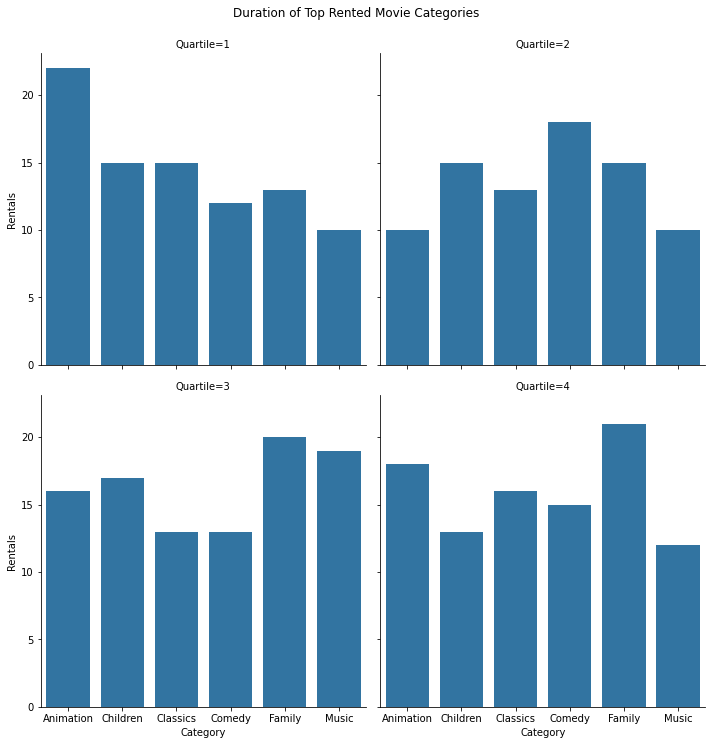

In [15]:
g = sns.catplot(data=df, kind='bar',
                x='category', y='rent_count',
                col='rent_dur_standard_quartile', col_wrap=2,
                color=base_color)
g.set(xlabel='Category', ylabel='Rentals')
g.set_titles('Quartile={col_name}')
g.fig.suptitle('Duration of Top Rented Movie Categories', y=1.03)
g.fig.savefig('images/top-movies-duration-quartile-grid.png')

### Question 3: How Can We Compare The Two Stores?

In [16]:
query = """
        SELECT  DATE_PART('month', rental_date) rental_month,
                DATE_PART('year', rental_date) rental_year,
                s.store_id,
                COUNT(*) month_rentals_count
        FROM rental r
        JOIN staff sf ON r.staff_id = sf.staff_id
        JOIN store s ON s.store_id = sf.store_id
        GROUP BY 1, 2, 3
        ORDER BY 2, 1, 4 DESC
        """
df = pd.read_sql(query, con=engine)
df.head()

,rental_month,rental_year,store_id,month_rentals_count
0,5.0,2005.0,2,598
1,5.0,2005.0,1,558
2,6.0,2005.0,1,1163
3,6.0,2005.0,2,1148
4,7.0,2005.0,2,3367


In [17]:
df[['rental_month', 'rental_year']] = df[['rental_month', 'rental_year']].astype(int)
df.head()

,rental_month,rental_year,store_id,month_rentals_count
0,5,2005,2,598
1,5,2005,1,558
2,6,2005,1,1163
3,6,2005,2,1148
4,7,2005,2,3367


In [18]:
df['rent_date'] = df['rental_year'].astype(str) + '-0' + df['rental_month'].astype(str)
df.head()

,rental_month,rental_year,store_id,month_rentals_count,rent_date
0,5,2005,2,598,2005-05
1,5,2005,1,558,2005-05
2,6,2005,1,1163,2005-06
3,6,2005,2,1148,2005-06
4,7,2005,2,3367,2005-07


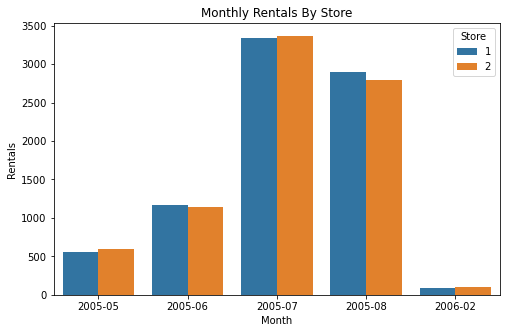

In [19]:
fig, ax = plt.subplots(figsize=(8, 5))
sns.barplot(data=df, x='rent_date', y='month_rentals_count', hue='store_id')
plt.xlabel('Month')
plt.ylabel('Rentals')
plt.legend(title='Store')
plt.title('Monthly Rentals By Store')
fig.savefig('images/monthly-rentals-store-bar.png')

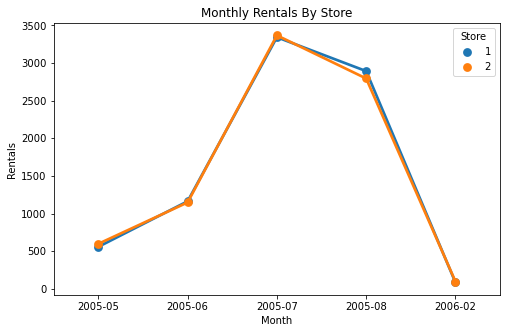

In [20]:
fig, ax = plt.subplots(figsize=(8, 5))
sns.pointplot(data=df, x='rent_date', y='month_rentals_count', hue='store_id');
plt.xlabel('Month')
plt.ylabel('Rentals')
plt.legend(title='Store')
plt.title('Monthly Rentals By Store');

fig.savefig('images/monthly-rentals-store-point.png')

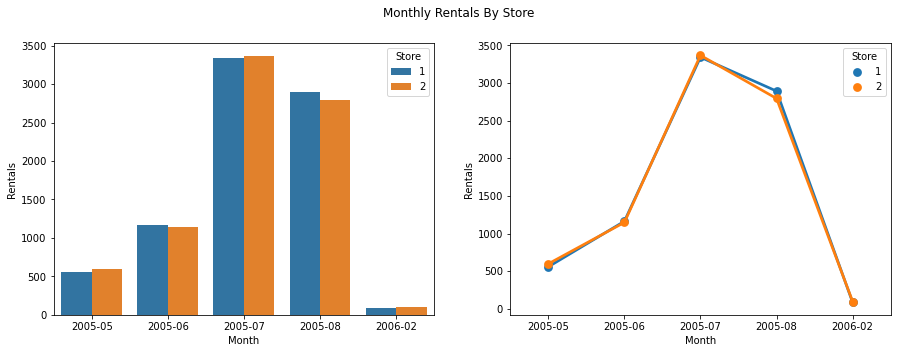

In [21]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
sns.barplot(data=df, x='rent_date', y='month_rentals_count', hue='store_id', ax=ax[0]);
ax[0].set_xlabel('Month')
ax[0].set_ylabel('Rentals')
ax[0].legend(title='Store')

sns.pointplot(data=df, x='rent_date', y='month_rentals_count', hue='store_id', ax=ax[1]);
ax[1].set_xlabel('Month')
ax[1].set_ylabel('Rentals')
ax[1].legend(title='Store')

fig.suptitle('Monthly Rentals By Store')
fig.savefig('images/monthly-rentals.png')

The number of rentals completed by both stores in any given month is approximately equal.

Both charts suggest an increase in rentals between May and Jult, then a decline in rentals between July and next February.

### Question 4: Who Are The Top Payers And How Did They Spend On Rentals In 2007?'

In [22]:
query = """
        WITH top_payers AS (
            SELECT  c.customer_id,
                    first_name || ' ' || last_name fullname,
                    SUM(amount) amount
            FROM payment p
            JOIN customer c ON c.customer_id = p.customer_id
            GROUP BY 1, 2 ORDER BY 3 DESC
            LIMIT 10
        )
        SELECT DISTINCT DATE_TRUNC('month', payment_date) pay_mon,
                fullname,
                COUNT(payment_id) OVER payment_window AS pay_count_permon,
                SUM(p.amount) OVER payment_window AS pay_amount_permon
        FROM payment p
        JOIN top_payers tp ON tp.customer_id = p.customer_id
        WHERE DATE_PART('year', payment_date) = 2007
        WINDOW payment_window AS (PARTITION BY fullname, DATE_TRUNC('month', payment_date) ORDER BY DATE_TRUNC('month', payment_date))
        ORDER BY fullname
        """

df = pd.read_sql(query, con=engine)
df.head()

,pay_mon,fullname,pay_count_permon,pay_amount_permon
0,2007-02-01,Ana Bradley,4,19.96
1,2007-03-01,Ana Bradley,16,71.84
2,2007-04-01,Ana Bradley,12,72.88
3,2007-05-01,Ana Bradley,1,2.99
4,2007-02-01,Clara Shaw,6,22.94


In [23]:
df.rename(columns={'pay_mon': 'date'}, inplace=True)
df.head()

,date,fullname,pay_count_permon,pay_amount_permon
0,2007-02-01,Ana Bradley,4,19.96
1,2007-03-01,Ana Bradley,16,71.84
2,2007-04-01,Ana Bradley,12,72.88
3,2007-05-01,Ana Bradley,1,2.99
4,2007-02-01,Clara Shaw,6,22.94


In [24]:
df['month'] = df['date'].dt.month_name()
df.head()

,date,fullname,pay_count_permon,pay_amount_permon,month
0,2007-02-01,Ana Bradley,4,19.96,February
1,2007-03-01,Ana Bradley,16,71.84,March
2,2007-04-01,Ana Bradley,12,72.88,April
3,2007-05-01,Ana Bradley,1,2.99,May
4,2007-02-01,Clara Shaw,6,22.94,February


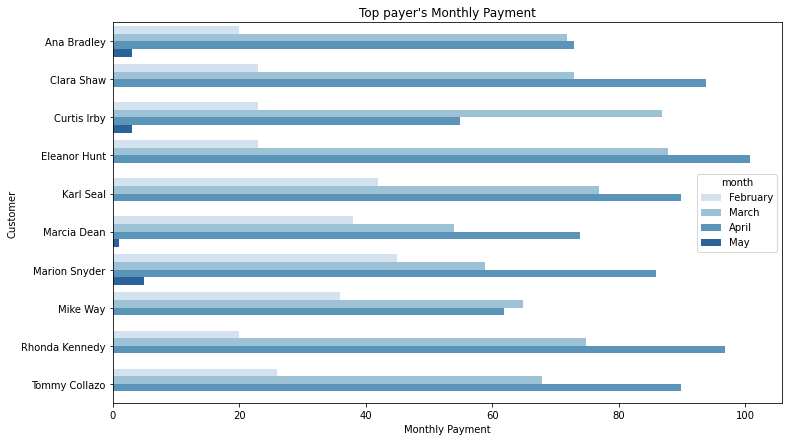

In [25]:
import numpy as np
fig = plt.figure(figsize=(12, 7))
sns.barplot(data=df, y='fullname', x='pay_amount_permon', estimator=np.sum, hue='month', palette='Blues')
plt.xlabel('Monthly Payment')
plt.ylabel('Customer')
plt.title("Top payer's Monthly Payment" )

fig.savefig('images/top-customers-monthly-payment-combined.png')

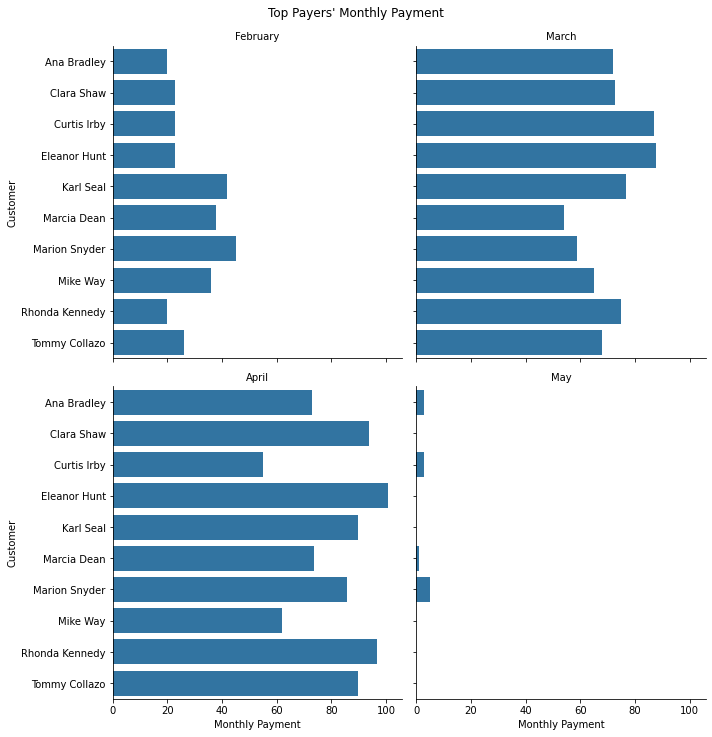

In [26]:
g = sns.catplot(data=df, y='fullname', x='pay_amount_permon', col='month', 
                kind='bar', estimator=np.sum, color=base_color, col_wrap=2)
g.set(xlabel='Monthly Payment', ylabel='Customer')
g.set_titles('{col_name}')
g.fig.suptitle("Top Payers' Monthly Payment", y=1.02)

g.fig.savefig('images/top-customers-monthly-payment-month-grid.png')

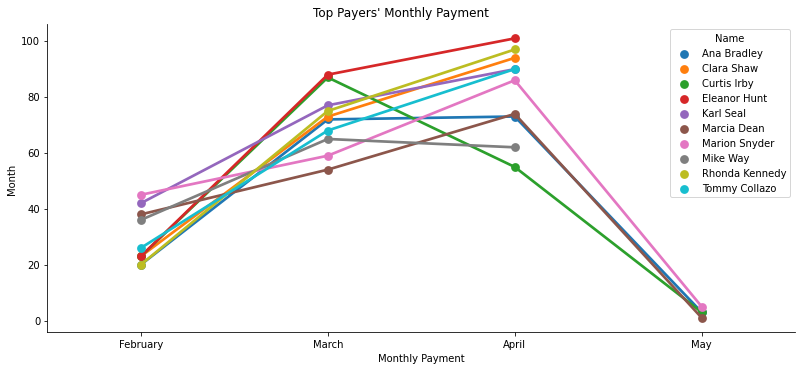

In [27]:
g = sns.catplot(data=df, hue='fullname', y='pay_amount_permon', x='month', 
            kind='point', estimator=np.sum, aspect=2.25, legend_out=False)
g.set(xlabel='Monthly Payment', ylabel='Month')
plt.legend(title='Name')
g.fig.suptitle("Top Payers' Monthly Payment", y=1.02)

g.fig.savefig('images/top-customers-monthly-payment-customer-point.png')

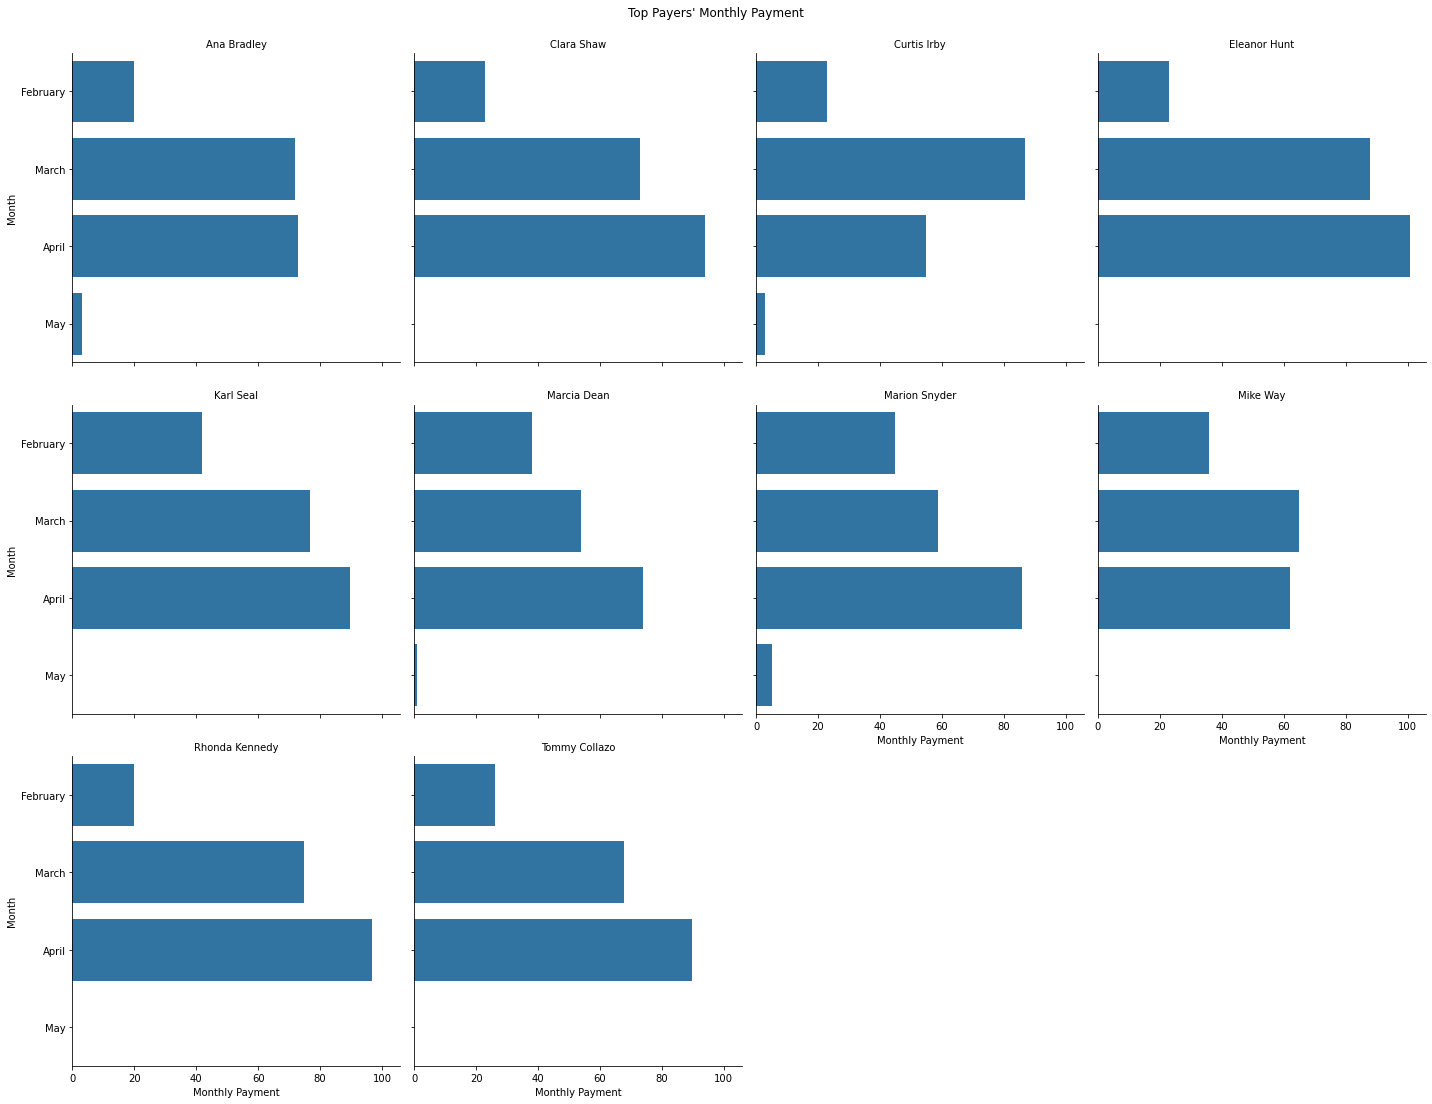

In [28]:
g = sns.catplot(data=df, col='fullname', x='pay_amount_permon', y='month', 
            kind='bar', estimator=np.sum, color=base_color, col_wrap=4)
g.set(xlabel='Monthly Payment', ylabel='Month')
g.set_titles('{col_name}')
g.fig.suptitle("Top Payers' Monthly Payment", y=1.02)

g.fig.savefig('images/top-customers-monthly-payment-customer-grid.png')

There is a similar pattern among all top payers. There is an increase in payments between Feruary and April. Then a payment decline in May. Only 4 customers (Ana Bradley, Curtis Irby, Marcia Dean and Marion Snyder) rented in May. 

The only exceptions whose payments declined from March to May are
- Curtis Irby with a major decline between March and April.
- Mike Way with a minor decline from March to April.
- Ana Bradley with the smallest decline from <March to April